<center>

<h1> Cont-Bouchaud Percoaltion Model for Stock Prices </h1>   
<h2> -- Python Experiments -- </h2>

<h4> Houssem Ben Romdhane </h4>

    
*****************
 

In this notebook, we run code snippets one at a time in order to visualize the different phenomena and generate the plots added in the thesis' report. The present file has the same structure used in the main deliverable and can be found under https://github.com/houssem-br/Cont-Bouchaud. It is a complement to the thesis and some parts of it can only be well understood by reading the corresponding sections. Please start by running the following block to import all packages required for a proper code execution and to set the plotting parameters. It might be necessary to manually install some of these packages. If this is the case, please run this command line, where you replace &lt;package-name&gt; by the name of the missing package.
```
python -m pip install <package-name>
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import statsmodels.api as sm 
import pylab as py 
import networkx as nx
import itertools
import random
from scipy.stats import norm, kurtosis, jarque_bera
from scipy.optimize import curve_fit

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (13, 4)
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['figure.dpi'] = 80

## 1. Analyzing Stylized Effects in Financial Markets

Stylized facts are non-trivial statistical properties that time series of financial assets have regardless of the instrument's nature or where it is being traded. They are empirical regularities observed in most stocks, derivatives, and foreign exchange rates across different markets whether in New York, Frankfurt, or Shanghai (Samanidou et al. 2007). There is no unanimously accepted exact definition of stylized facts. Accordingly, no exhaustive list of these features exists. This chapter is therefore restricted to the stylized features most relevant to the discussion and evaluation of the Cont-Bouchaud model. The statistical analyses conducted in the next sections are for the most part inspired from Ehrentreich 2008 and Rydberg 2000.

### 1.1. Heavy Tails

Observations of financial markets confirm that time series of log-returns are characterized by a leptokurtic behavior, i.e., a higher than normal occurrence of extreme events. This empirical regularity can be portrayed by a heavy-tailed distribution and is the subject matter of this section.  

A substantial number of empirical studies found that for shorter time scales, the frequency of extreme events in empirical log-returns is larger than what might occur if they followed a normal distribution. The figure below shows for example the DAX daily log-returns from January 1988 to December 2020 and compares their density to normally distributed returns with the same mean and variance. Clearly, the actual log-returns are high-peaked and heavy-tailed as compared to the normal distribution. Notice also that the left tail is longer: The mass of the distribution is concentrated on the right side of the density plot and relatively dispersed to the left. This indicates a negative sample skewness (i.e., third standardized moment), whereas a normal distribution is perfectly symmetric.

[*********************100%***********************]  1 of 1 completed


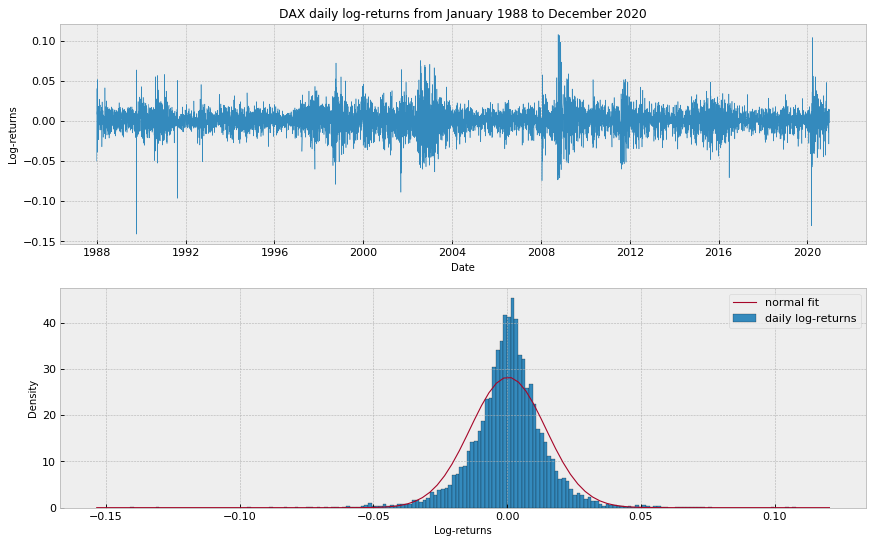

In [2]:
def log_returns(stock, interval, period):
    price = yf.download(stock, period=period, interval=interval);
    returns = np.diff(np.log(price['Adj Close']))
    dates = [dt.datetime.strptime(str(i)[:19],'%Y-%m-%d %H:%M:%S') for i in price.index[:-1]]
    return dates, returns

plt.figure(figsize=(13,8))
dates, returns = log_returns('^GDAXI', '1d', 'max')
plt.subplot(211)
plt.plot(dates, returns, linewidth=.5)
plt.title(r'DAX daily log-returns from January 1988 to December 2020')
plt.xlabel('Date')
plt.ylabel(r'Log-returns')
plt.subplot(212)
plt.hist(returns, bins='auto', density=True, label='daily log-returns', edgecolor='k', linewidth=.2)
mu, std = norm.fit(returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
fit_norm = norm.pdf(x, mu, std)
plt.plot(x, fit_norm, linewidth=1, label='normal fit')
plt.legend()
plt.xlabel('Log-returns')
plt.ylabel('Density')
plt.show()

Out of the more than $8328$ samples collected (on December 20, 2020), $134$ are at least $3$-$\sigma$ events, $19$ are less likely than a $5$-$\sigma$ event, and two are at least $9$-$\sigma$ events. The distribution is in this case leptokurtic with a sample kurtosis (i.e., fourth standardized moment) of around $9.7$. This confirms the differences the tail of DAX daily log-returns have compared to the normal distribution.

In [3]:
_, returns = log_returns('^GDAXI', '1d', 'max')
sample_size = returns.size
print('\nOf the %d samples collected:' % returns.size)
for i in range(3, 10):
    print(r'    * %3d are at least a %d-sigma event' %(returns[np.abs(returns) > i * np.std(returns)].size, i))

[*********************100%***********************]  1 of 1 completed

Of the 8333 samples collected:
    * 134 are at least a 3-sigma event
    *  43 are at least a 4-sigma event
    *  19 are at least a 5-sigma event
    *   8 are at least a 6-sigma event
    *   5 are at least a 7-sigma event
    *   2 are at least a 8-sigma event
    *   2 are at least a 9-sigma event


The kurtosis is one way to study the "Gaussianity" of sample data. Another way is to perform a Jarque-Bera test: A goodness-of-fit test. The test statistic $JB$ is defined as 
\begin{equation*}
    JB = \frac{n}{6} \left\{ \left( \frac{\hat{\mu}_3}{\hat{\mu}_2^{3/2}} \right)^2 + \frac{1}{4} \left( \frac{\hat{\mu}_4}{\hat{\mu}_2^2} - 3 \right)^2\right\} ,
\end{equation*}
where $n$ is the sample size and $\hat{\mu}_i$ is an estimate of the sample's $i$-th central moment. The Jarque-Bera statistic follows a chi-squared distribution with two degrees of freedom if the observations are normally distributed. For the DAX daily log-returns, $JB$ is large with a $p$-value of $0$. This result allows us to safely reject the null hypothesis that they stem from a normal distribution.

In [4]:
_, returns = log_returns('^GDAXI', '1d', 'max')
print('\nThe sample kurtosis of DAX daily log-returns is %f \n' % kurtosis(returns, fisher=False))
print('The JB-statistic amounts to %f, which corresponds to a p-value of %f\n' % jarque_bera(returns))

[*********************100%***********************]  1 of 1 completed

The sample kurtosis of DAX daily log-returns is 9.700581 

The JB-statistic amounts to 15723.244242, which corresponds to a p-value of 0.000000



This behavior is of course not uniquely observed in the German stock market index but is rather a recurring pattern that was identified across various markets and financial instruments and is valid for different time increments as the next two tables show.

In [5]:
stock_dict_daily = {'^GDAXI':'DAX', '^GSPC':'S&P 500', '^N225':'Nikkei', '^NSEI':'NIFTY 50', 'OGZPY':'Gazprom', 'TSLA':'Tesla', 'DB':'Deutsche Bank', 'GBP=X':'GBP/USD', 'GC=F':'Gold Futures', 'BTC=F':'Bitcoin Futures'}
df_daily = pd.DataFrame(columns=['Kurtosis', 'JB', 'p-value'])
for stock in stock_dict_daily:
    _, returns = log_returns(stock, '1d', '2y')
    jb_value, p = jarque_bera(returns)
    df_daily.loc[stock_dict_daily[stock], 'Kurtosis'] = kurtosis(returns, fisher=False)
    df_daily.loc[stock_dict_daily[stock], 'JB'] = jb_value
    df_daily.loc[stock_dict_daily[stock], 'p-value'] = p
print(df_daily)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                Kurtosis       JB p-value
DAX              16.8784  4128.28       0
S&P 500          18.1574  4912.82       0
Nikkei           9.17486  766.266       0
NIFTY 50         21.8899  7532.99       0
Gazprom          16.0438  3571.35       0
Tesla             7.5898  458.425       0
Deutsche Bank   

In [6]:
stock_dict_hourly = {'^GDAXI':'DAX','^GSPC':'S&P 500', '^N225':'Nikkei', '^NSEI':'NIFTY 50', 'OGZPY':'Gazprom', 'TSLA':'Tesla', 'DB':'Deutsche Bank', 'GBP=X':'GBP/USD'}
df_hourly = pd.DataFrame(columns=['Kurtosis', 'JB', 'p-value'])
for stock in stock_dict_hourly:
    _, returns = log_returns(stock, '1h', '2y')
    jb_value, p = jarque_bera(returns)
    df_hourly.loc[stock_dict_daily[stock], 'Kurtosis'] = kurtosis(returns, fisher=False)
    df_hourly.loc[stock_dict_daily[stock], 'JB'] = jb_value
    df_hourly.loc[stock_dict_daily[stock], 'p-value'] = p
print(df_hourly)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
              Kurtosis          JB p-value
DAX             39.555      253507       0
S&P 500        52.7881      364183       0
Nikkei         36.4843      135518       0
NIFTY 50       114.634  1.7785e+06       0
Gazprom        57.5413      435218       0
Tesla          28.2576     93339.5       0
Deutsche Bank  30.7758      112983       0
GBP/USD        24.5086      238797       0


Log-returns of financial assets are hence unlikely to be Gaussian, especially for daily or intraday time scales. Their exact distribution, however, remains an open question with far-reaching consequences on many financial applications such as value-at-risk estimations and options' pricing. A myriad of parametric models have been proposed over the years to account for this particular stylized fact: Stable distributions, the Student distribution, hyperbolic distribution, and exponentially truncated stable distribution just to name a few. Mandelbrot, for instance, studied the time series of cotton futures and concluded that the probability to have a large change in price decays with a power-law. He therefore dismissed the Gaussian model as inaccurate and proposed a Lévy-stable model for financial returns (Cont 2001). The following figure portrays the different tail behaviors of both models. Most current models fail to replicate all stylized facts at once, but there is a general agreement among researchers that the tails of log-returns decay as a power-law (Samanidou 2007).

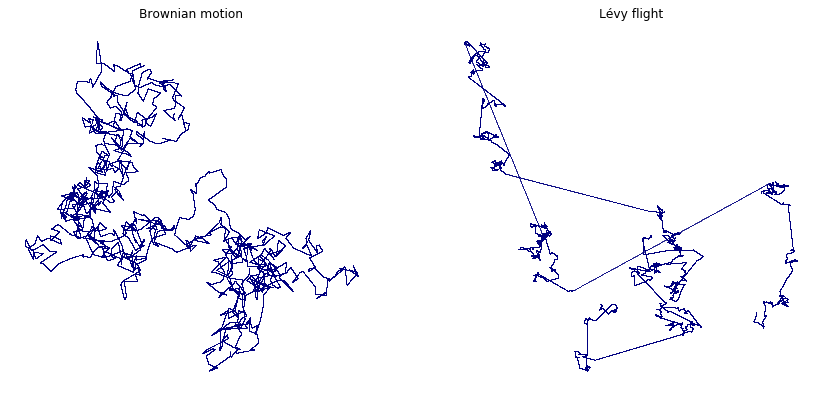

In [7]:
np.random.seed(1994)
n = 1000
plt.figure(figsize=(13,6))

x_bm = np.cumsum(np.random.randn(n))
y_bm = np.cumsum(np.random.randn(n))
k = 200
x1 = np.interp(np.arange(n * k), np.arange(n) * k, x_bm)
y1 = np.interp(np.arange(n * k), np.arange(n) * k, y_bm)
plt.subplot(121)
plt.title('Brownian motion')
plt.scatter(x1, y1, c='navy', linewidths=0, s=.5)
plt.axis('off')

alpha = 1.5
r_aux = np.random.randn(n)
r = np.sign(r_aux) * np.power(np.abs(r_aux), -1/alpha)
theta = np.random.randn(n) * 2 * np.pi
x_lf = np.cumsum(r  * np.cos(theta))
y_lf = np.cumsum(r  * np.sin(theta))
k = 400
x2 = np.interp(np.arange(n * k), np.arange(n) * k, x_lf)
y2 = np.interp(np.arange(n * k), np.arange(n) * k, y_lf)
plt.subplot(122)
plt.title('Lévy flight')
plt.scatter(x2, y2, c='navy', linewidths=0, s=.5)
plt.axis('off')

plt.show()

When dealing with a distribution that is decaying as a power-law $\sim x^{-\mu}$, one usually seeks to estimate the exponent $\mu$ near the tails. In this case, the Hill estimator offers a common and straightforward method. Let $X_1, X_2, \dots, X_n$ the random variables describing log-returns of a price process. For some threshold $k_n$, one can extract the highest $k_n +1$ log-returns $R_{1} \geq R_{2} \geq \dots \geq R_{k_n} \geq R_{k_n +1}$. The estimator for the tail index $\mu$, the Hill estimator, is
\begin{equation*}
    \hat{\mu}_n = \left( \frac{1}{k_n} \sum_{i=1}^n \log \frac{R_i}{R_{k_n +1}}\right)^{-1}.
\end{equation*}
Applying the Hill estimator to the daily DAX log-returns yields an estimate of roughly $3.26$ in the positive tail and approximately $3.27$ in the negative one.

In [8]:
_, returns = log_returns('^GDAXI', '1d', 'max')
sorted_returns = np.sort(returns) 
abs_sorted_returns = np.sort(np.abs(returns))[::-1]
thresh = 150   
mu_pos = 1/(np.mean(np.log(sorted_returns[0:thresh]/sorted_returns[thresh])))
mu_neg = 1/(np.mean(np.log(sorted_returns[-thresh:]/sorted_returns[-thresh])))
mu_all = 1/(np.mean(np.log(abs_sorted_returns[0:thresh]/abs_sorted_returns[thresh])))
print('\nFor a threshold of %d, the exponent is' % thresh)
print('    * in the positive tail: %.3f' % mu_pos)
print('    * in the negative tail: %.3f' % mu_neg)
print('    * in both tails       : %.3f' % mu_all)

[*********************100%***********************]  1 of 1 completed

For a threshold of 150, the exponent is
    * in the positive tail: 3.257
    * in the negative tail: 3.269
    * in both tails       : 3.605


### 1.2. Aggregational Gaussianity

In this section, we discuss aggregational Gaussianity, a closely related stylized fact states that the distribution of log-returns tends towards a Gaussian law for increasing sampling periods. Indeed, we have seen in the previous section that log-returns are unlikely to be Gaussian-distributed as they are characterized by much heavier tails. This is, however, only true for daily or intraday time scales. For decreasing sampling frequencies, e.g. weekly or monthly, the distribution of log-returns was found to converge to a Gaussian. The following table supports this claim as a Jarque-Bera test fails to reject the null hypothesis and the kurtosis is nearly $3$ for the selected financial instruments.

In [9]:
stock_dict_quarterly = {'^GDAXI':'DAX', '^GSPC':'S&P 500', '^N225':'Nikkei', '^NSEI':'NIFTY 50', 'GBP=X':'GBP/USD', 'GC=F':'Gold Futures', 'BTC=F':'Bitcoin Futures'}
df_quarterly = pd.DataFrame(columns=['Kurtosis', 'JB', 'p-value'])
for stock in stock_dict_quarterly:
    _, returns = log_returns(stock, '3mo', '5y') 
    jb_value, p = jarque_bera(returns)
    df_quarterly.loc[stock_dict_daily[stock], 'Kurtosis'] = kurtosis(returns, fisher=False)
    df_quarterly.loc[stock_dict_daily[stock], 'JB'] = jb_value
    df_quarterly.loc[stock_dict_daily[stock], 'p-value'] = p
print(df_quarterly)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                Kurtosis        JB   p-value
DAX              2.53735  0.506137  0.776415
S&P 500          3.48461  0.220045  0.895814
Nikkei            2.7369  0.335898  0.845397
NIFTY 50          2.5885  0.813213  0.665906
GBP/USD          2.90503  0.408692   0.81518
Gold Futures     2.44799  0.345902  0.841179
Bitcoin Futures  3.05197  0.189618  0.909546


Alternatively, Q-Q plots provide a pictorial explanation of the differences between high and low sampling frequencies, which may be more revealing. The following figure shows the Q-Q plots of daily, weekly, monthly, and quarterly DAX log-returns against the fitted normal distribution. Q-Q plots facilitate graphical comparisons between two probability distributions by mapping out their quantiles against one another. The top panels, which coincide with lower sampling periods, show more mass in the tails in line with the previous section. The plots corresponding to lower sampling frequencies, however, feature lower mass especially along the right tail, which suggests that they do indeed tend to a Gaussian.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


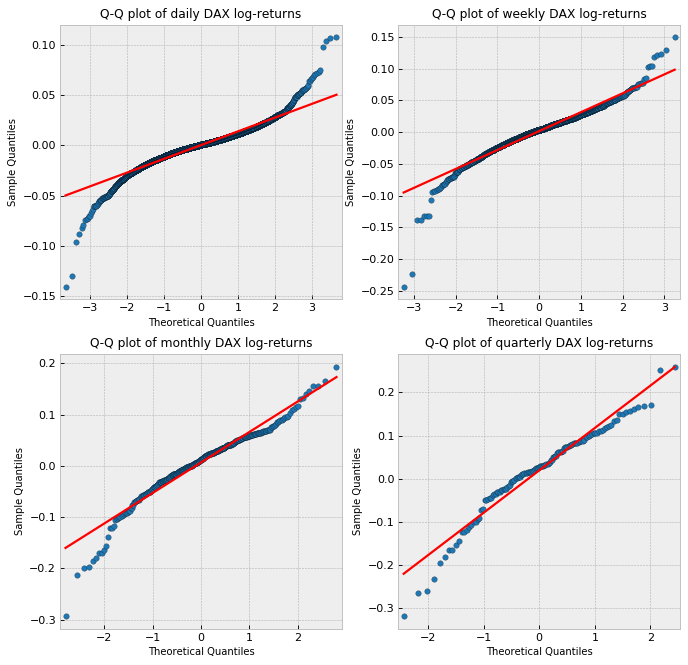

In [10]:
def plot_qq(interval, period, ax):
    _, returns = log_returns('^GDAXI', interval, period)
    sm.qqplot(returns, line='r', markersize=5, markerfacecolor='tab:blue', markeredgecolor='k', markeredgewidth=.2, ax=ax) 

intervals = {'1d':'daily', '1wk':'weekly', '1mo':'monthly', '3mo':'quarterly'}
fig = plt.figure(figsize=(10, 10))
for i, interval in enumerate(intervals, 221):
    ax = fig.add_subplot(i)
    plot_qq(interval, 'max', ax)
    ax.set_title('Q-Q plot of %s DAX log-returns' % intervals[interval])
plt.show() 

### 1.3. Volatility Clustering

To wrap up this chapter, we give a brief review of empirical evidence supporting the existence of a third stylized fact: Volatility clustering, which, as the name suggests, means that volatility comes in clusters. If financial markets witness large price fluctuations today, then there is a higher-than-average probability to observe considerable price variations tomorrow as well (Samanidou 2007). From a statistical point of view, the persistence of volatility and its partial predictability imply that volatility is serially correlated. The raw, absolute, and squared daily log-returns of the DAX index are depicted in the next plot: While raw returns themselves are mostly uncorrelated and fluctuate around $0$, the squared and absolute log-returns display a positive, slowly decaying autocorrelation function for increasing time lags. This is a well-known quantitative manifestation of volatility clustering.

[*********************100%***********************]  1 of 1 completed


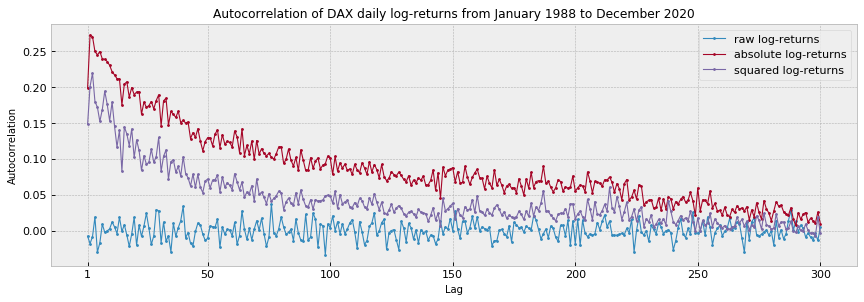

In [11]:
def autocorr(x, maxlags):
    corr =np.correlate(x - x.mean(),x - x.mean(),'full')[len(x)-1:] / (np.var(x) * len(x))
    return corr[1:min(len(corr),maxlags)]

_, returns = log_returns('^GDAXI', '1d', 'max')
series = {'raw log-returns': returns, 'absolute log-returns':np.abs(returns), 'squared log-returns':np.power(returns, 2)}
for serie in series:
    plt.plot(range(1,301), autocorr(series[serie], 301), label=serie, linewidth=1, marker='o', markersize=1.5)
plt.title('Autocorrelation of DAX daily log-returns from January 1988 to December 2020')
plt.xlabel('Lag')
plt.xticks([1,50,100,150,200,250,300])
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

## 2. The Cont-Bouchaud Model
We consider a market of $N$ agents trading one financial asset following the price process $\{S_t\}$ as proposed by Cont and Bouchaud \cite{Cont.2000}. At each time step $t \in \mathbb{N}$, an agent can either buy, sell, or hold her position. We model the choice of agent $i$ using a random variable $\phi_t^i \in \{ -1, 0, +1 \}$, where $\phi_t^i = +1$ refers to a buy decision, $\phi_t^i = -1$ describes a propensity to sell, and $\phi_t^i = 0$ means that agent $i$ chooses not to trade. 

Under normal circumstances, the log-returns of a stock within one period $R_t$ is proportional to the aggregate excess demand $D_t = \sum_{i=1}^N \phi_t^i$ of that asset after all agents have made their trading decisions, i.e.,
\begin{equation}\label{eq: price change}
{R_t} = \log \left( \frac{S_{t}}{S_{t-1}}\right) \propto  \sum_{i=1}^N \phi_t^i .
\end{equation}

We showed that the relationship between the net order $D_t$ and log-returns can be assumed to be linear for short sampling periods, i.e., for $|D_t| \ll N$, which, for some $\lambda > 0$, yields the equation
\begin{equation}
    R_t = \log S_{t} - \log S_{t-1} = \frac{1}{\lambda} \sum_{i=1}^N \phi_t^i
\end{equation}

Now we assume that members of a given cluster $C_\alpha$ adopt a common trading strategy, i.e., $\phi_t^i = \phi_t^j$ for all $a_i, a_j \in C_\alpha$. Log-returns can therefore be rewritten as a sum over clusters
\begin{equation}
    R_t = \frac{1}{\lambda} \sum_{\alpha=1}^{n_c} W_\alpha \phi_t^\alpha ,
\end{equation}
where $W_\alpha = |C_\alpha|$ is the cluster size and $\phi_t^\alpha$ is the common trading decision made by the agents belonging to cluster $C_\alpha$. A group's decision can be assumed independent from its size and specified using a random variable $\phi_t^\alpha \in \{-1, 0, +1\}$ with probability mass function
\begin{equation}
P(\phi_t^\alpha = \varphi)=\left\{\begin{array}{ll}
\frac{a}{2}, & \text { for } \varphi \in \{-1, +1\} \\
1 - a , & \text { for } \varphi = 0 
\end{array}\right. ,\end{equation}
where we impose the constraint $a < \frac{1}{2}$. Let $X_\alpha = W_\alpha \phi_t^\alpha$ be the total demand of cluster $C_\alpha$. Asset returns can now be stated in terms of $X_\alpha$ as
\begin{equation}\label{eq: cb log returns}
    R_t = \frac{1}{\lambda} \sum_{\alpha=1}^{n_c} X_\alpha .
\end{equation}

The statistics of the log-returns $R_t$ can therefore be reduced to an analysis of the cluster size distribution: A problem that was deeply investigated in the theory of random graphs. In our attempt to derive an analytical formula of the kurtosis, we resorted to the following beautiful theorem from graph theory, Cayley's formula:
For $k \geq 2$, denote by $T_k$ the number of trees on $k$ labeled vertices. Then,
\begin{equation*}
    T_k = k^{k-2}
\end{equation*}

The next code block produces and displays all $4^{4-2} = 16$ trees on $4$ colored vertices.

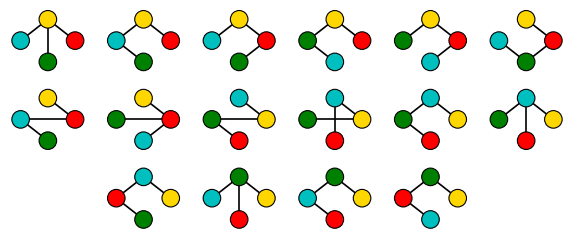

In [12]:
# adapted from https://stackoverflow.com/questions/62116491/how-can-i-get-all-the-tree-graphs-given-a-certain-numbers-of-nodes-networkx?answertab=active#tab-top
num_nodes = 4
edges =  [a for a in itertools.product(range(num_nodes), range(num_nodes))]
edges = list(set([tuple(set(e)) for e in edges]))
edges = [e for e in edges if len(e)>1]
trees = []
for o in itertools.combinations(edges, num_nodes-1):
    flattened = [item for sublist in o for item in sublist]
    if len(set(flattened)) == num_nodes:
        G = nx.Graph()
        G.add_edges_from(o, length=5)
        if len(list(nx.connected_components(G)))==1:
            trees.append(G)
plt.figure(figsize=(9,5))
k = 0
colors = ['r', 'gold', 'c', 'g']
for idx, tree in enumerate(trees,1):
    if idx > 12:
        k = 1
    plt.subplot(4,6,idx+k)
    pos = nx.circular_layout(tree, scale=.3)
    nx.draw(tree, pos=pos, node_color=[colors[i] for i in tree.nodes()], node_size=250, edgecolors='k', linewidths=1, width=1.5)
    plt.axis('off')
plt.show()

After determining the distribution of cluster sizes and the cumulant-generating function of the total number of clusters and devising a relationship between the moments of $X'$ and $R_t$, we got the following closed form expression for the kurtosis of log-returns
\begin{equation}
    \kappa(R_t) = \frac{3}{4 n_o \left(1 - \frac{c}{2}\right) \left(c - 1 - \log c \right)^2} + 3,
\end{equation}
where $n_o$ is number of incoming orders during a unit of time.

For values of $c$ close to $1$, i.e., $0 < 1-c \ll 1$, the distribution of log-returns is clearly leptokurtic as shown in the figure below. For  $c \to 1^{-}$, the excess kurtosis becomes very large, which suggests that log-returns become nearly flat-topped in the middle with extremely high peaks around the extremes $r_t = \pm N \lambda^{-1}$. This observation is in line the graph theoretical interpretation of the critical value $c^* = 1$ where a giant cluster emerges as $N \to \infty$. Indeed, if almost all investors decide to coordinate their trades at each time step, we would expect log-returns to be solely impacted by decision of the cluster they form. For values of $c$ going to $0$ however, $\kappa(R_t) \to 3$, i.e., the tail behavior of log-returns approaches that of a normal distribution. A situation in which the agents make their investment decisions (almost) independently results in nearly normally distributed log-returns.

The figure below also depicts the change in excess kurtosis for different values of $n_o$ as well. For $c= 0.9$ and $n_o = 1000$ for instance, $\kappa(R_t) \approx 50$, which is a reasonable value in highly liquid markets even for smaller time scales. Recall that the choice of $n_o$ is tightly linked with the time scale to be considered: An increase in the trading period is usually accompanied by a rise in the number of orders. For $n_o \to \infty$, log-returns clearly converge to a mesokurtic distribution which agrees with the empirical observations of stylized facts in financial markets.

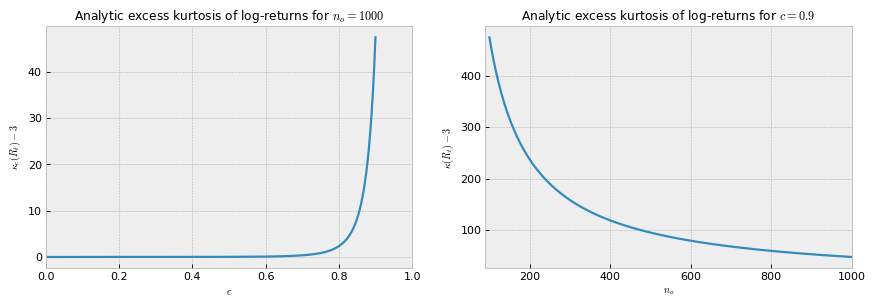

In [13]:
def excess_kappa(c, n_o):
    return 3 / (4 * n_o * (1 - .5 * c) * (c - 1 - np.log(c))**2) 

n_o = 1000
v_c = np.linspace(10**-5, 0.9, num=10**3)
plt.subplot(121)
plt.plot(v_c, excess_kappa(v_c, n_o))
plt.xlabel(r'$c$')
plt.ylabel(r'$\kappa_c(R_t) - 3$')
plt.title(r'Analytic excess kurtosis of log-returns for $n_o = %d$' % n_o)
plt.xlim((0, 1))
plt.subplot(122)
c = 0.9
v_n_o = np.linspace(10**2, 10**3, num=10**3)
plt.plot(v_n_o, excess_kappa(c, v_n_o))
plt.xlabel(r'$n_o$')
plt.ylabel(r'$\kappa(R_t) - 3$')
plt.title(r'Analytic excess kurtosis of log-returns for $c = %.1f$' % c)
plt.xlim((10**2-10, 10**3))
plt.show()

### 2.1. Model Visualization

Most properties derived analytically are valid for infinite random graphs. One might, however, ask the question whether the quantities of interest behave in a similar manner in large but finite graphs and if so, how similar. After all, financial markets consist of a finite number of participants. Finite-size scaling and the renormalization group theory deliver a theoretical answer to this questions. We chose to walk a different path by actually running simulations of the Cont-Bouchaud model to verify the extent to which the statements made in the previous section are valid and investigate some of its interesting aspects. All simulations were run using python's networkx package for the creation and manipulation of random graphs and clustering of vertices. 

We start with a visualization of an Erdős–Rényi graph $G_{N,{c}/{N}}$ for $N=10000$ and $c=1.1$, where clusters can be differentiated by color. The vertices were positioned using the Fruchterman-Reingold force-directed algorithm which pushes smaller clusters towards the periphery.

The biggest cluster contains 1017 vertices, i.e., ~ 10.17 percent of the total.


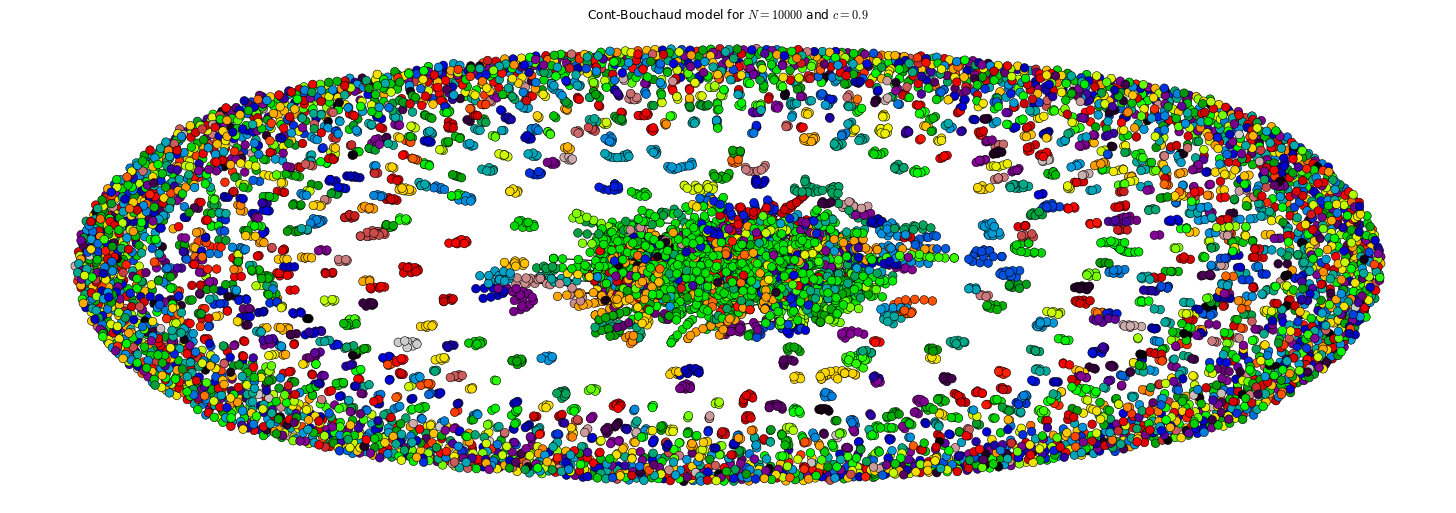

In [14]:
def visualize_model(N, c, return_max_cluster=False):
    p = c / N
    G = nx.erdos_renyi_graph(N, p)
    clusters = list(nx.connected_components(G))
    node_color_init = np.array([[clusters.index(c) for c in clusters if i in c][0] for i in range(N)])
    shuffle_colors = np.arange(node_color_init.size)
    np.random.shuffle(shuffle_colors)
    node_color = np.array([shuffle_colors[i] for i in node_color_init])
    nx.draw(G, cmap=plt.get_cmap('nipy_spectral'), node_color=node_color, node_size=60, edge_color='k', edgecolors='k', linewidths=0.5)
    if return_max_cluster:
        return max([len(c) for c in clusters])

N = 10**4
plt.figure(figsize=(18,6))
max_cluster = visualize_model(N, 1.1, True)
plt.title(r'Cont-Bouchaud model for $N = %d$ and $c = %.1f$' % (N, c))
print('The biggest cluster contains %d vertices, i.e., ~ %4.2f percent of the total.' % (max_cluster, 100 * max_cluster / N))

### 2.2. Cluster Size Distribution

The following figure depicts the histogram of cluster sizes generated in one realization of the Cont-Bouchaud model with a total number of $N= 10000$ market participants and a connectivity $c = 0.9$ below the threshold. A truncated power-law with an exponent $\approx 2.48$ seems to fit perfectly to the components' size distribution. A large fraction of investors remain isolated and a slightly smaller number coordinated their trades in couples. Cluster sizes start then decaying following a power-law. 

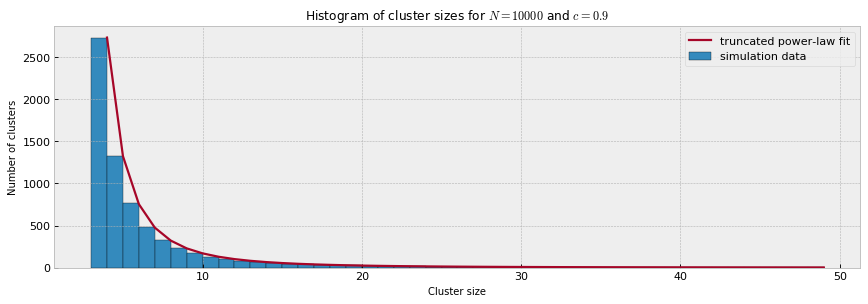

In [15]:
def trunc_power_law(x, k_0):
    return len(cluster_sizes) * k_0 * np.power(x,-2.5) * np.exp(-(-np.log(c) - 1 + c) * x)

N = 10000
c = .9
p = c / N
T = 10**3
cluster_sizes = []
for _ in range(T):
    G = nx.erdos_renyi_graph(N, p)
    cluster_sizes.extend([len(c) for c in nx.connected_components(G)])
cluster_sizes = np.array(cluster_sizes)
cluster_dist, _, _ = plt.hist(cluster_sizes[cluster_sizes > 2], bins=range(3,50), label='simulation data', weights=.01 * np.ones(shape=cluster_sizes[cluster_sizes > 2].shape), edgecolor='black', linewidth=.3)
x = np.array(range(3,49))
y = cluster_dist
popt, pcov = curve_fit(trunc_power_law, x, y)

plt.plot(x+1, trunc_power_law(x, *popt), label='truncated power-law fit')
plt.legend()
plt.xlabel('Cluster size')
plt.ylabel('Number of clusters')
plt.title(r'Histogram of cluster sizes for $N=%d$ and $c=%.1f$' % (N, c))
plt.show()

### 2.3. Asset Returns' Distribution

We now verify whether the model, despite finite-size effects, yields the expected heavy tails in the distribution of log-returns. The figures below show the log-returns and price movements for one realization of the Cont-Bouchaud market. One can easily notice that the tails of log-returns' distribution are heavier than normal: Whether positive or negative, extreme values are more frequent than what we would expect if log-returns were Gaussian-distributed. Indeed, the kurtosis in this case amounts to $37.12$, confirming the latter observation. Tail values of log-returns clearly result in jumps in the price time series, e.g., at time steps around $200$, $380$, or $670$, generating a Lévy-like walk. The Cont-Bouchaud model certainly replicates the heavy-tails of log-returns. Moreover, the partial results it yields suggest that the resulting distribution is indeed a power-law, in agreement with what we discussed in Section 1.1.

In [16]:
def random_decision(a):
    u = np.random.uniform()
    if u < .5 * a:
        return -1
    elif u > 1 - .5 * a:
        return 1
    else:
        return 0            

N = 10**4
a = 10**-4
T = 10**3
c = .9
p = c / N
v_net_demand = np.empty(shape=(T,1))
for t in range(T):
    G = nx.erdos_renyi_graph(N, p)
    cluster_sizes = np.array([len(c) for c in nx.connected_components(G)])
    cluster_decisions = np.array([random_decision(a) for _ in range(len(cluster_sizes))])
    v_net_demand[t] = np.sum(cluster_sizes * cluster_decisions)  

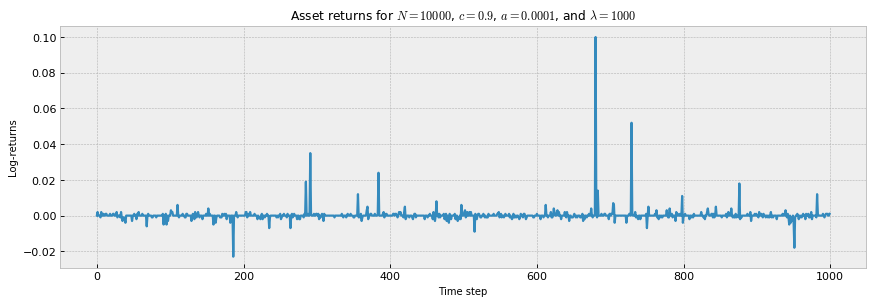

In [17]:
lmbda = 10**3
v_returns = v_net_demand / lmbda
plt.plot(v_returns)
plt.xlabel('Time step')
plt.ylabel('Log-returns')
plt.title(r'Asset returns for $N=%d$, $c=%.1f$, $a= %.4f$, and $\lambda = %d$ ' % (N, c, a, lmbda))
plt.show()

In [18]:
print('The kurtosis of asset returns is: %.2f' % kurtosis(v_returns, fisher=False))

The kurtosis of asset returns is: 324.18


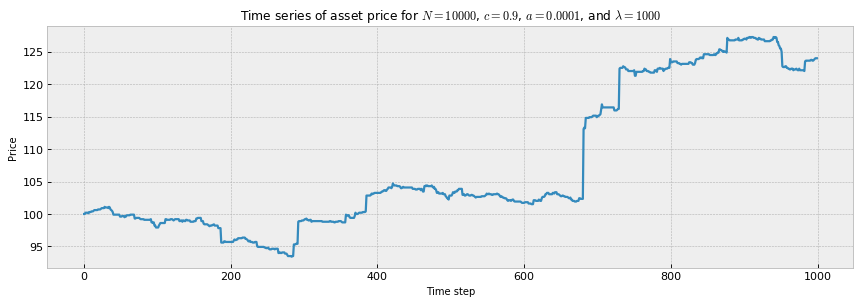

In [19]:
def get_price_from_demand(demand, lmbda):
    v_price = np.empty(shape=(len(demand),1))
    v_price[0] = 100
    for t in range(len(demand)-1):
        v_price[t+1] = np.exp(demand[t] / lmbda) * v_price[t]
    return v_price

lmbda = 1000
v_price = get_price_from_demand(v_net_demand, lmbda) 
plt.plot(range(T), v_price)
plt.xlabel('Time step')
plt.ylabel('Price')
plt.title(r'Time series of asset price for $N=%d$, $c=%.1f$, $a= %.4f$, and $\lambda = %d$ ' % (N, c, a, lmbda))
plt.show()

The Cont-Bouchaud model, as defined in the original paper, is static, i.e., no rule was defined to enable a realistic transition from one time step to the next. One has to fix the connectivity parameter $c$ artificially. In each trading period, agents form clusters, make a common decision to remain inactive, buy, or sell the financial asset and then, the clusters shatter to allow the formation of new groups in the next period. Clearly, such a mechanism does not grant a transfer of information for a time interval to the next. Hence, serially correlated volatility could never arise. An analysis of the autocorrelation function of generated log-returns corroborates this observation. The autocorrelations of raw, absolute, and squared log-returns all fluctuate around $0$ for lags up to $300$.

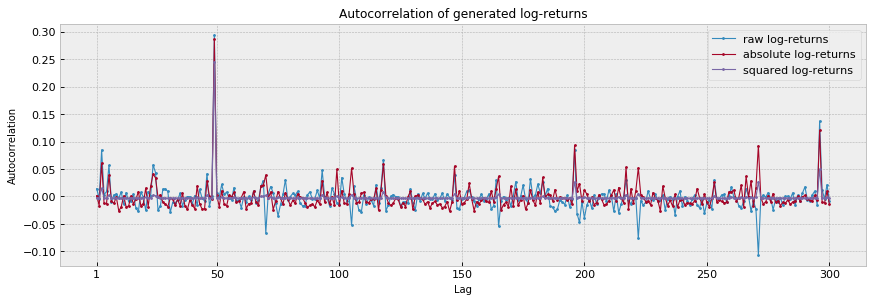

In [20]:
returns = np.array(v_returns)[:, 0]
series = {'raw log-returns': returns, 'absolute log-returns':np.abs(returns), 'squared log-returns':np.power(returns, 2)}
for serie in series:
    plt.plot(range(1,301), autocorr(series[serie], 301), label=serie, linewidth=1, marker='o', markersize=1.5)
plt.title('Autocorrelation of generated log-returns')
plt.xlabel('Lag')
plt.xticks([1,50,100,150,200,250,300])
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

### 2.4. Crossover for Increasing Time Scales

The second stylized fact we discussed previously is aggregational Gaussianity, i.e., the tendency of the distribution of log-returns towards a Gaussian law as the sampling frequency decreases. One way to investigate this behavior for the Cont-Bouchaud model is by measuring the kurtosis for increasing values of market activity $a$. Recall that smaller $a$ necessarily means smaller time scales and vice versa. \Cref{fig: sim kurtosis} depicts the kurtosis by market activity based on one realization over $1000$ time steps for each value of $a$. A Monte Carlo simulation would have delivered more robust results, but was not possible due to the limited computing power available. Nonetheless, the trend is easily discernible. The kurtosis is very high for small values of $a$, reaching up to $400$ in one case. As $a$ increases, the kurtosis starts decaying until eventually stabilizing around $3$, where the tail behavior of log-returns resembles that of a normal distribution.

In [22]:
N = 10000
T = 10**3
c = .8
p = c / N
G = nx.erdos_renyi_graph(N, p)
cluster_sizes = np.array([len(c) for c in nx.connected_components(G)])
v_a = np.linspace(.00005, 0.005, endpoint=True, num=10**3)
v_kurt_co = []
for a in v_a: 
    v_demand = []
    for _ in range(T):
        cluster_decisions = np.array([random_decision(a) for _ in range(len(cluster_sizes))])
        excess_demand = np.sum(cluster_sizes * cluster_decisions)
        v_demand.append(excess_demand) 
    v_kurt_co.append(kurtosis(v_demand, fisher=False))

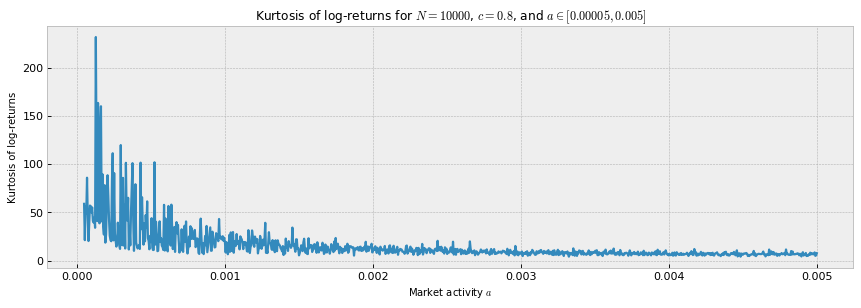

In [24]:
plt.plot(v_a, v_kurt_co)
plt.xlabel(r'Market activity $a$')
plt.ylabel('Kurtosis of log-returns')
plt.title(r'Kurtosis of log-returns for $N=%d$, $c=%.1f$, and $a \in [0.00005, 0.005]$' % (N, c))
plt.show()

### 2.5. Bubbles and Crashes

Interestingly, the methodological holism underlying the model's dynamics can also be used to study market panics and financial bubbles. Recall that herding behavior is even more apparent during times of crisis or speculative manias. The most recent stock market crash was for instance accentuated by large and simultaneous sell-offs. When panics break out, they spread like wildfires. As a matter of fact, herding was not only observed in financial market: People flocked to supermarkets to buy toilet paper and preserved foods, putting severe strains on supply chains. 

Even though the Cont-Bouchaud model as described in the previous sections is rather static, one may ponder a situation in which the market connectivity $c$ grows at a slow pace until crossing the threshold $c^* = 1$. Once beyond it, the clusters dissolve and $c$ is reinitialized to a value inferior to the critical threshold. This is particularly reasonable in the case of market panics since steep declines in stock market indexes automatically trigger circuit breakers. Fama offered an alternative explanation and argued that some crashes, especially when preceded by speculative bubbles, could be seen as an efficient reassessment of the fundamental price.

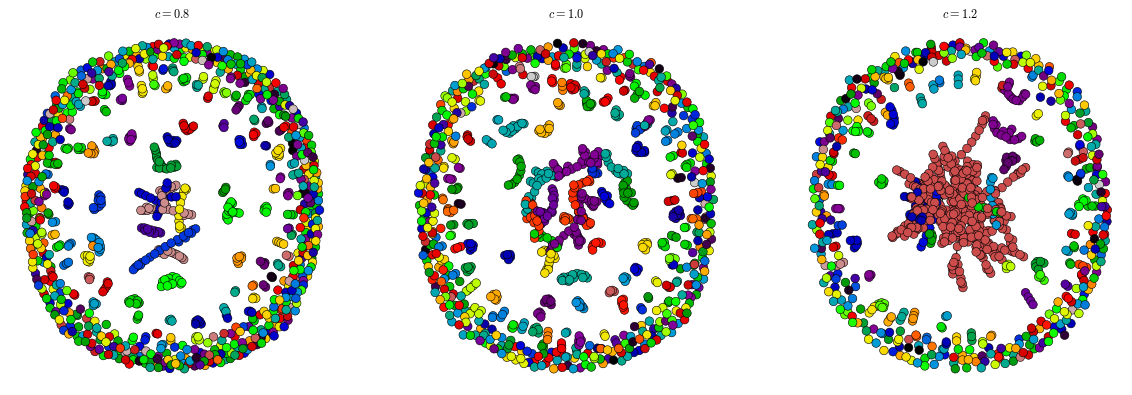

In [25]:
N = 10**3
plt.figure(figsize=(18,6))
for i, c in enumerate([0.8, 1, 1.2], 131):
    plt.subplot(i)
    visualize_model(N, c)
    plt.title(r'$c=%.1f$' % c)

plt.show()

In [26]:
N = 2000
a = 10**-3
v_c = np.linspace(0.8, 1.2, num=10**3)
v_net_demand = np.empty(shape=(len(v_c)+1,1))
for t, c in enumerate(v_c, 0):
    p = c / N
    G = nx.erdos_renyi_graph(N, p)
    cluster_sizes = np.array([len(c) for c in nx.connected_components(G)])
    cluster_decisions = np.array([random_decision(a) for _ in range(len(cluster_sizes))])
    v_net_demand[t] = np.sum(cluster_sizes * cluster_decisions) 

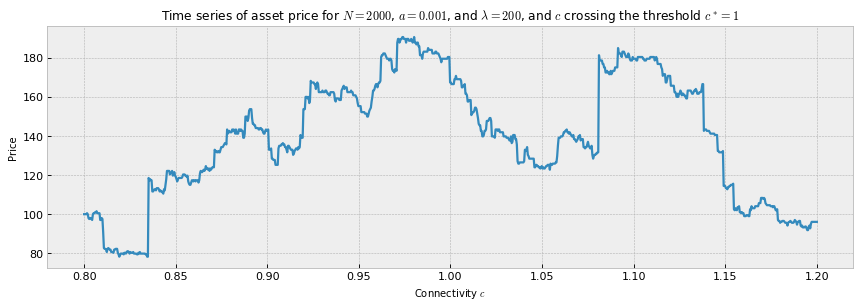

In [27]:
lmbda = 200
v_price = get_price_from_demand(v_net_demand, lmbda)   
plt.plot(v_c, v_price[:-1])
plt.xlabel(r'Connectivity $c$')
plt.ylabel('Price')
plt.title(r'Time series of asset price for $N=%d$, $a= %.3f$, and $\lambda = %d$, and $c$ crossing the threshold $c^*=1$' % (N, a, lmbda))
plt.show() 

## 3. Extensions of the Cont-Bouchaud Model
Cont and Bouchaud's model, an infinite range bond percolation, has the merit of replicating some of the non-trivial stylized facts in spite of its simplicity. It has, however, its shortcomings which unfortunately make it a meager candidate to explain the empirical regularities in financial time series. Coupled with the well-known properties of percolation models, this motivated a myriad of variations aiming at offsetting some of its limitations, adapting it to explain other phenomena in financial markets, or using it as a basis to design policy recommendations. 

In this chapter, we focus on two such variations. One of the most cited modifications of the original Cont-Bouchaud model is a nearest-neighbor site percolation where agents are in constant motion. This dynamic induces a positive and slowly decaying volatility as we shall see in the first section. Then, we review an Ising-type model where agents form their decision through nearest-neighbor interactions. 

### 3.1. Site Percolation on the Square Lattice
In a bid to make the Cont-Bouchaud model more dynamic, Stauffer et al. proposed to force agents to move within the market instead of the continuous shattering and formation of clusters (Stauffer et al. 1999). To this end, traders have to be positioned on a lattice of a predetermined geometry. The authors chose to distribute the $N$ agents on a two-dimensional square lattice $L^2$. Clustering occurs by nearest-neighbor interactions, i.e., every two vertices that are in each other's direct (or von Neumann) neighborhood are necessarily linked. The emerging clusters then make their random trading decisions as per the original Cont-Bouchaud model. The figure below shows the ensuing market, the aggregation of clusters, and the decision making process. The new setting corresponds to a site percolation model.

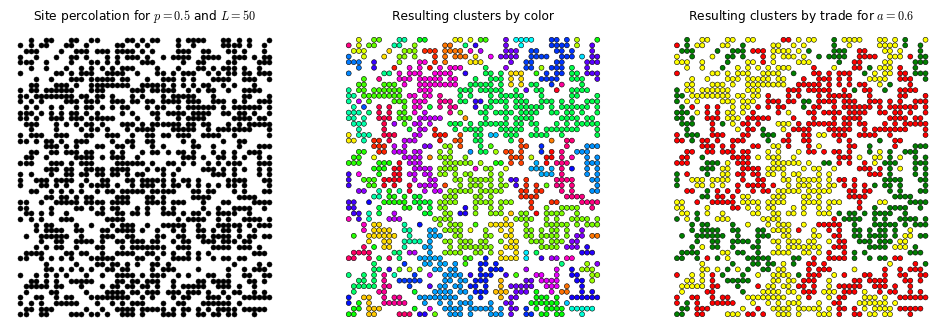

In [28]:
def random_decision(a):
    u = np.random.uniform()
    if u < .5 * a:
        return -1
    elif u > 1 - .5 * a:
        return 1
    else:
        return 0 
    
L = 50
p = .5
G = nx.grid_2d_graph(L,L)
not_nodes = []
for node in G.nodes():
    if np.random.uniform() < 1 - p:
        not_nodes.append(node)
G.remove_nodes_from(not_nodes)
pos = dict((n, n) for n in G.nodes())
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.gca().set_title(r'Site percolation for $p = %.1f$ and $L = %d$' % (p, L))
nx.draw_networkx_nodes(G, pos=pos, node_size=20, with_label=False, node_color='k')
plt.axis('off')
clusters = list(nx.connected_components(G))
node_color_init = np.array([[clusters.index(c) for c in clusters if i in c][0] for i in G.nodes()])
shuffle_colors = np.arange(node_color_init.size)
np.random.shuffle(shuffle_colors)
node_color = np.array([shuffle_colors[i] for i in node_color_init])
plt.subplot(132)
plt.gca().set_title(r'Resulting clusters by color')
nx.draw_networkx_nodes(G, pos=pos, node_size=20, with_label=False, cmap=plt.get_cmap('hsv'), node_color=node_color, edgecolors='k', linewidths=.5)
plt.axis('off')
a = .6
cluster_decision = [random_decision(a) for _ in shuffle_colors]
colors = ['red', 'yellow', 'green']
node_decision = [colors[cluster_decision[i]+1] for i in node_color]
plt.subplot(133)
plt.gca().set_title(r'Resulting clusters by trade for $a = %.1f$' % a)
nx.draw_networkx_nodes(G, pos=pos, node_size=20, with_label=False, cmap=plt.get_cmap('hsv'), node_color=node_decision, edgecolors='k', linewidths=.5)
plt.axis('off')
plt.show()

In contrast to Bachelier's random walk model, where prices diffuse for a time step to the next, Stauffer et al. proposed a model in which randomness arises from the diffusion of agents on a two-dimensional square lattice. They defined two rules of motion. The simplest consists in moving agents to a random empty neighboring site and results in a local change of cluster sizes. In the second variant, agents are allowed to move to any of the lattice's empty site. By implementing these rules, one would expect to observe serial correlation of squared or absolute log-returns.

In [29]:
def get_empty_neighbors(node, not_nodes):
    empty_neighbors = []
    for adjacent in [(0,1), (0,-1), (1,0), (-1,0)]:
        candidate = (node[0] + adjacent[0], node[1] + adjacent[1])
        if candidate in not_nodes:
            empty_neighbors.append(candidate)
    return empty_neighbors
    
def run_sim_square_lattice(L, p, T, G, delta, a=None, motion_rule='nearest'):
    not_nodes = [x for x in itertools.product(range(L), repeat=2) if x not in G.nodes()]
    v_net_demand = np.empty(shape=(T,1))
    for t in range(T):
        cluster_sizes = np.array([len(c) for c in nx.connected_components(G)])                                    
        if a is None:
            cluster_decisions = np.array([random_decision(.1 * cluster_size**-.5) for cluster_size in cluster_sizes])
        else:
            cluster_decisions = np.array([random_decision(a) for _ in range(len(cluster_sizes))])
        v_net_demand[t] = np.sum(cluster_sizes * cluster_decisions)
        nodes = list(G.nodes())
        for node in nodes:
            if np.random.uniform() < delta:
                if motion_rule == 'nearest':
                    destinations = get_empty_neighbors(node, not_nodes)
                else:
                    destinations = not_nodes
                if not not destinations:
                    destination = random.choice(destinations)
                    not_nodes.remove(destination)
                    not_nodes.append(node)
                    G.remove_node(node)
                    G.add_node(destination)
                    new_empty_neighbors = get_empty_neighbors(destination, not_nodes)
                    for adjacent in [(0,1), (0,-1), (1,0), (-1,0)]:
                        candidate = (destination[0] + adjacent[0], destination[1] + adjacent[1])
                        if (candidate not in new_empty_neighbors) and (candidate[0] > -1) and (candidate[0] < L) and (candidate[1] > -1) and (candidate[1] < L):
                            G.add_edge(destination, candidate)
    return v_net_demand
    
L = 30
T = 10**3
delta = .01
p = 0.5
a = .01 
v_order_nearest = np.zeros(shape=(T,1))
v_order_free = np.zeros(shape=(T,1))
for idx in range(1, 2):
    G = nx.grid_2d_graph(L,L)
    not_nodes = []
    for node in G.nodes():
        if np.random.uniform() < 1 - p:
            not_nodes.append(node)
    G.remove_nodes_from(not_nodes)
    v_order_nearest = ((idx-1) * v_order_nearest + run_sim_square_lattice(L, p, T, G, delta, a, motion_rule='nearest')) / idx
    v_order_free = ((idx-1) * v_order_free + run_sim_square_lattice(L, p, T, G, delta, a, motion_rule='free')) / idx

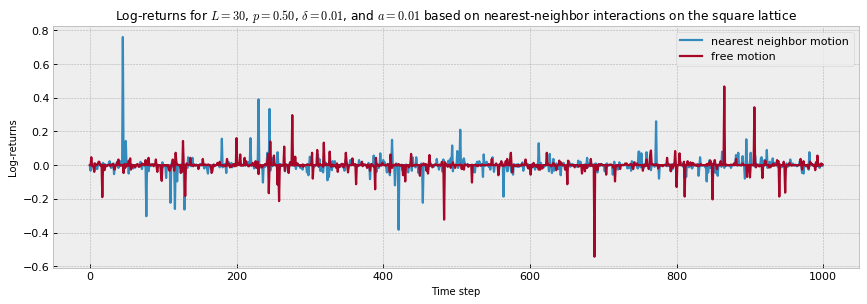

In [30]:
lmbda = 300
plt.plot(v_order_nearest/lmbda, label='nearest neighbor motion')
plt.plot(v_order_free/lmbda, label='free motion')
plt.xlabel('Time step')
plt.ylabel('Log-returns')
plt.title(r'Log-returns for $L=%d$, $p=%.2f$, $\delta=%.2f$, and $a= %.2f$ based on nearest-neighbor interactions on the square lattice' % (L, p, delta, a))
plt.legend()
plt.show()

In [31]:
print('The kurtosis of asset returns is \n')
print('* for nearest-neighbor motion: %.2f' % kurtosis(v_order_nearest, fisher=False))
print('* for any-free-site    motion: %.2f' % kurtosis(v_order_free, fisher=False))

The kurtosis of asset returns is 

* for nearest-neighbor motion: 106.39
* for any-free-site    motion: 73.46


We previously assumed that the market activity $a$ is constant and smaller than $N$. Since the total number of market participants here depends on the chosen probability $p$ and the random removal of vertices, such an assumption would be unspecific for percolation models. Instead, we assume that $a$ is inversely proportional to the total number of sites, i.e., $a \approx L^{-d}$. Stauffer and Sornette proposed to define a cluster-specific, size-dependent activity $a_\alpha = W_\alpha^{-1/2}$. Indeed, the tendency of big investment institutions to adopt long-term strategies might justify their smaller market activity. Much to the contrary, smaller professional investors and noisy traders usually attempt to generate profits from short-term trading in part due to the limited capital available

In [32]:
L = 30
T = 10**3
delta = .01
p = .55
v_order = np.zeros(shape=(T,1))
G = nx.grid_2d_graph(L,L)
not_nodes = []
for node in G.nodes():
    if np.random.uniform() < 1 - p:
        not_nodes.append(node)
G.remove_nodes_from(not_nodes)
v_order_a_sd = ((idx-1) * v_order + run_sim_square_lattice(L, p, T, G, delta, motion_rule='free')) / idx

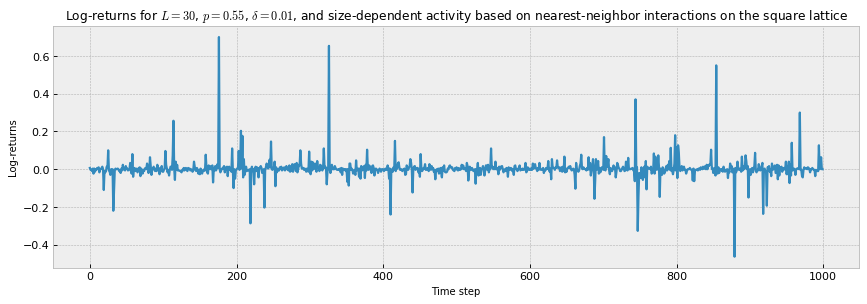

In [33]:
lmbda = 300
plt.plot(v_order_a_sd/lmbda)
plt.xlabel('Time step')
plt.ylabel('Log-returns')
plt.title(r'Log-returns for $L=%d$, $p=%.2f$, $\delta=%.2f$, and size-dependent activity based on nearest-neighbor interactions on the square lattice' % (L, p, delta))
plt.show()

In [34]:
print('The kurtosis of asset returns is %.2f' % kurtosis(v_order_a_sd, fisher=False))

The kurtosis of asset returns is 65.96


### 3.2. Ising-Type Model

The Ising model is a mathematical framework of ferromagnetism. It broadly consists of sites arranged on a square lattice, each having one of two states (called spin). The spin in each site changes sequentially through nearest-neighbor interactions until reaching some sort of equilibrium, giving rise to a complex dynamic. 

In the present model, agents represent the sites a two-dimensional square lattice $L^2$ similar to the one discussed in the previous section. Therefore, the total number of investors is $N = L^2$. The spins, representing the trading decision, are assumed to take one of three possible values: At each time step $t$, agent $a_i$ can either buy stock, sell stock, or remain neutral for $Z_t^i \in \{+1, -1, 0\}$, respectively. However, unlike the other variants of the Cont-Bouchaud model, investment decisions are constrained by the amount of cash $N_t^i$ and the units of stock $M_t^i$ that agent $a_i$ has at time $t$. We assume that all investors start with the same amount of cash $N_0^i$ and equal units of stock $M_0^i$ and that at each time step, at most one unit of stock can be traded. An agent's decision $Z_t^i$ depends on a uniformly distributed idiosyncratic noise $\nu_t^i \sim \operatorname{Unif}([-1,+1])$ and the signals it receives from its nearest neighbors. 

During each trading period, agents enter ``consultation rounds": A period during which communication occurs sequentially and repeatedly until reaching an equilibrium. We denote by $\tilde{t}$ a time within a period during which the consultation rounds take place, i.e., $\tilde{t} \in [t, t+\Delta t)$. Thus, we could define an intra-period aggregate signal of agent $a_i$ as
\begin{equation*}
    Y_{\tilde{t}}^i = \beta \nu_t^i + \sum_{j\in \mathcal{I}_i} J_{ij} Z_{\tilde{t}}^j , 
\end{equation*}
where $\mathcal{I}_i = \{k \in \mathbb{N}: a_k \in A \text{ and }||a_j-a_k||_2 = 1\}$, i.e., the set of direct neighbors of $a_i$. $J_{ij} = J_{ji}$ describes the influence agents $a_i$ and $a_j$ have on each other and can take any value in $[0,1]$. Hence, two different forces shape the intra-period aggregate signal: A random idiosyncratic signal and an external influence exerted by the nearest neighbors. The former introduces disorder and the latter tends to restore order. This heterogeneous behavior depends primarily on the exact choice of $J_{ij}$. Taking $J_{ij} = 1$ results in roughly all agents making the same trading decision: An event that calls to mind the emergence of a giant cluster in the original Cont-Bouchaud model and would cause large fluctuations in prices. Choosing $J_{ij} = 0$ reduces the system to utter randomness and yields Gaussian-distributed returns. Interestingly, choosing $J_{ij} = 1$ with probability $p$ and $J_{ij} = 0$ with probability $1-p$ bring us back to the framework of the Cont-Bouchaud model. We assume the latter option in what follows since it is more general and can reproduce the other two for $p = 1$ and $p = 0$, respectively. 

For each $\tilde{t}$, $Y_{\tilde{t}}^i$ is interpreted as a signal to buy, sell, or remain inactive. In order to allow a fraction of traders to remain neutral, we introduce an individual threshold $\xi_t^{i} \in (-1,1)$ which, unless exceeded in absolute terms, prevents agent $a_i$ from trading. Not introducing this threshold results in a system where every trader buys or sells at the slightest positive or negative signal. The intra-period trading decision can thus be defined as 
\begin{equation*}
Z_{\tilde{t}}^{i}=\left\{\def\arraystretch{1.2}\begin{array}{lll}
1, & \text { for } & \xi_t^{i} \leq Y_{\tilde{t}}^{i} \\
0, & \text { for } & -\xi_t^{i}<Y_{\tilde{t}}^{i}<\xi_t^{i} \\
-1, & \text { for } & Y_{\tilde{t}}^{i} \leq-\xi_t^{i}
\end{array}\right. .
\end{equation*}

Once the consultation rounds are concluded, all agents submit their trading decisions. The aggregate excess demand $D_t$ can be computed and the price is updated using the formula 
\begin{equation*}
    S_{t+1} = S_t \left( \frac{|a_i \in A: Z_t^i > 0|}{|a_i \in A: Z_t^i < 0|} \right)^\alpha,
\end{equation*}
where $\alpha = D_t/N$. As discussed in the previous sections, the emergence of serially correlated log-returns hinges on the proper implementation of agent memory. This can be achieved by assuming that price variations lead to an adjustment of individual thresholds following the equation
\begin{equation*}
    \xi_{t+1}^i = \xi_t^i \frac{S_{t+1}}{S_t}.
\end{equation*}

In [35]:
L = 30
beta = .2
T = 10**3
p = 0
a = 1
J = [[[1 if np.random.uniform() < p else 0 for _ in range(4)] for _ in range(L)] for _ in range(L)]
xi = np.abs(np.random.normal(loc=0, scale=1, size=(L,L)))
price = np.empty(shape=T)
price[0] = 1
cash = 100 * np.ones(shape=(L,L)) * price[0]
stock = 100 * np.ones(shape=(L,L))
for t in range(1, T):
    nus = np.random.uniform(low=-1, high=1, size=(L,L))
    old_signals = np.zeros(shape=(L,L))
    new_signals = np.zeros(shape=(L,L))
    for i in range(L):
        for j in range(L):
            if nus[i,j] > xi[i,j]:
                new_signals[i,j] = 1
            elif nus[i,j] < -xi[i,j]:
                new_signals[i,j] = -1
            else:
                new_signals[i,j] = 0
    old_cond = 0
    new_cond = np.count_nonzero((old_signals - new_signals)==0)
    while old_cond != new_cond:
        old_signals = np.copy(new_signals)
        old_cond = np.copy(new_cond)
        for i in range(L):
            for j in range(L):
                y_ij = beta * nus[i,j] + J[i][j][0] * old_signals[(i+1)%L,j] + J[i][j][1]  * old_signals[(i-1)%L,j] + J[i][j][2]  * old_signals[i,(j+1)%L] + J[i][j][3]  * old_signals[i,(j-1)%L]
                if y_ij > xi[i,j]:
                    new_signals[i,j] = 1
                elif y_ij < -xi[i,j]:
                    new_signals[i,j] = -1
                else:
                    new_signals[i,j] = 0
        new_cond = np.count_nonzero((old_signals - new_signals)==0)
    final_signals = np.copy(new_signals)
    for i in range(L):
        for j in range(L):
            if final_signals[i,j] == 1:
                if cash[i,j] < price[t-1]:
                    final_signals[i,j] = 0
                else:
                    cash[i,j] = cash[i,j] - price[t-1] 
                    stock[i,j] = stock[i,j] + 1
            if final_signals[i,j] == -1:
                if stock[i,j] < 1:
                    final_signals[i,j] = 0
                else:
                    cash[i,j] = cash[i,j] + price[t-1]
                    stock[i,j] = stock[i,j] - 1
    alpha = a * np.sum(np.abs(final_signals)) / (L**2)
    price[t] = price[t-1] * (np.count_nonzero(final_signals==1)/np.count_nonzero(final_signals==-1))**.1
    xi[i,j] = xi[i,j] * price[t] / price[t-1]

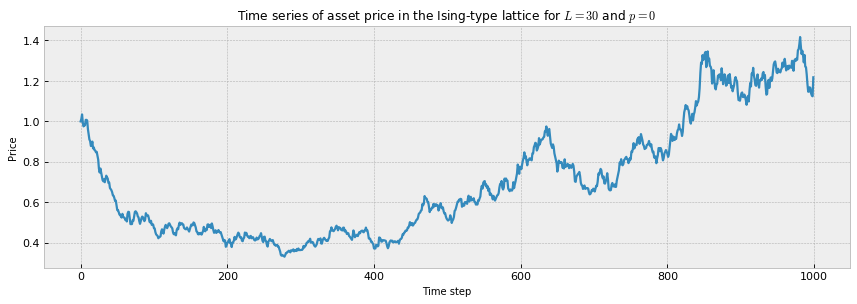

In [36]:
plt.plot(price)
plt.xlabel('Time step')
plt.ylabel('Price')
plt.title(r'Time series of asset price in the Ising-type lattice for $L=%d$ and $p=%.0f$' % (L, p))
plt.show()